In [1]:
import math
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal
from math import log10

[Matteo-Device:79006] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.Matteo-Device.1000/jf.0/3894149120/shared_mem_cuda_pool.Matteo-Device could be created.
[Matteo-Device:79006] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [2]:
fuel=openmc.Material(name='fuel')
fuel.add_nuclide('Pu238',2.332,'wo')
fuel.add_nuclide('Pu239',56.873,'wo')
fuel.add_nuclide('Pu240',26.997,'wo')
fuel.add_nuclide('Pu241',6.105,'wo')
fuel.add_nuclide('Pu242',7.693,'wo')
fuel.add_nuclide('U234',0.003,'wo')
fuel.add_nuclide('U235',0.404,'wo')
fuel.add_nuclide('U236',0.010,'wo')
fuel.add_nuclide('U238',99.583,'wo')
fuel.set_density("g/cc", 11)
fuel.depletable=True
fuel.temperature=2500 #Kelvin


clad=openmc.Material(name='clad')
clad.add_element('Cr',15.0,'wo')
clad.add_element('Ni',15.0,'wo')
clad.add_element('Mo',1.5,'wo')
clad.add_element('Mn',1.5,'wo')
clad.add_element('Si',0.9,'wo')
clad.add_element('Ti',0.4,'wo')
clad.add_element('C',0.09,'wo')
clad.set_density("g/cc",5)
clad.depletable=True
clad.temperature=900 #Kelvin

LM=openmc.Material(name='LM')
LM.add_element("Pb",1)
LM.set_density('g/cm3', 10.0)
LM.temperature=900 #Kelvin

mats=openmc.Materials((fuel,clad,LM))
mats.export_to_xml()

In [3]:
r_pin=openmc.ZCylinder(r=0.45)
fuel_cell=openmc.Cell(fill=fuel, region=-r_pin)
LM_cell=openmc.Cell(fill=LM , region=+r_pin)
pin_universe=openmc.Universe(cells=(fuel_cell, LM_cell))

r_big_pin = openmc.ZCylinder(r=0.57)
clad_cell = openmc.Cell(fill=clad, region=-r_big_pin)
LM2_cell = openmc.Cell(fill=LM, region=+r_big_pin)
big_pin_universe = openmc.Universe(cells=(clad_cell, LM2_cell))

all_LM_cell=openmc.Cell(fill=LM)
outer_universe=openmc.Universe(cells=(all_LM_cell,))

In [4]:
lat=openmc.HexLattice()

In [5]:
lat.center=(0.,0.)
lat.pitch=(1.36,)
lat.outer=outer_universe

In [6]:
print(lat.show_indices(3))

            (0, 0)
      (0,11)      (0, 1)
(0,10)      (1, 0)      (0, 2)
      (1, 5)      (1, 1)
(0, 9)      (2, 0)      (0, 3)
      (1, 4)      (1, 2)
(0, 8)      (1, 3)      (0, 4)
      (0, 7)      (0, 5)
            (0, 6)


In [7]:
outer_rig=[big_pin_universe]+[pin_universe]*11
middle_rig=[big_pin_universe]+[pin_universe]*5
inner_rig=[big_pin_universe]
lat.universes=[outer_rig,middle_rig,inner_rig]
print(lat)

HexLattice
	ID             =	4
	Name           =	
	Orientation    =	y
	# Rings        =	3
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.36,)
	Outer          =	3
	Universes      
  2
 1 1
1 2 1
 1 1
1 2 1
 1 1
1 1 1
 1 1
  1


In [8]:
outer_surface=openmc.ZCylinder(r=4,boundary_type='vacuum')
main_cell=openmc.Cell(fill=lat, region=-outer_surface)
geom=openmc.Geometry([main_cell])
geom.export_to_xml()

In [9]:
p=openmc.Plot.from_geometry(geom)
p.color_by='material'
p.colors = colors = {
    LM: 'blue',
    fuel: 'olive',
    clad: 'yellow'
}
#p.to_ipython_image()

In [10]:
# Change the orientation of the lattice and re-export the geometry
lat.orientation = 'x'
geom.export_to_xml()

# Run OpenMC in plotting mode
#p.to_ipython_image()

/home/orion/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


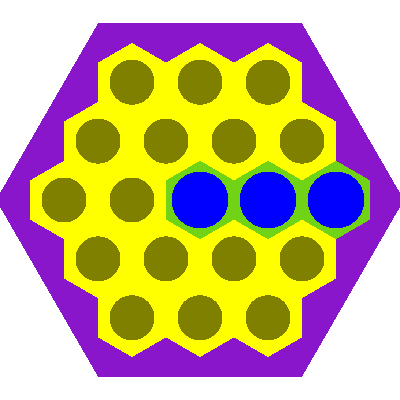

In [11]:
main_cell.region = openmc.model.hexagonal_prism(
    edge_length=3*lat.pitch[0],
    orientation='x',
    boundary_type='vacuum'
)
geom.export_to_xml()

# Run OpenMC in plotting mode
p.color_by = 'cell'
p.to_ipython_image()

In [12]:
settings = openmc.Settings()
settings.particles = 1000
settings.inactive = 10
settings.batches = 50

In [13]:
fuel.volume = math.pi * 0.25 ** 2
clad.volume = math.pi * (0.5-0.45) ** 2

In [14]:
chain = openmc.deplete.Chain.from_xml("../chain_endfb80_sfr.xml")
#chain.nuclide_dict

In [15]:
model = openmc.Model(geometry=geom, settings=settings)
operator = openmc.deplete.CoupledOperator(model, "../chain_endfb80_sfr.xml")

In [16]:
power = 210
time_steps = [30] * 6

In [17]:
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')

In [18]:
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Na23 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Na23.h5
 Reading Mg24 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Mg24.h5
 Reading Mg25 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Mg25.h5
 Reading Mg26 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Mg26.h5
 Reading Al27 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Al27.h5
 Reading P31 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/P31.h5
 Reading S32 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S32.h5
 Reading S33 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S33.h5
 Reading S34 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S34.h5
 Reading S36 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S36.h5
 Reading Cl35 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cl35.h5
 Reading Cl37 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cl37.h5
 Reading Ar36 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ar36.h5
 Reading Ar38 from /home/orion/Downloads/endfb-v

 Reading K40 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/K40.h5
 Reading K41 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/K41.h5
 Reading Ca40 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca40.h5
 Reading Ca42 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca42.h5
 Reading Ca43 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca43.h5
 Reading Ca44 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca44.h5
 Reading Ca46 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca46.h5
 Reading Ca48 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca48.h5
 Reading Sc45 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sc45.h5
 Reading V50 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/V50.h5
 Reading V51 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/V51.h5
 Reading Fe54 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Fe54.h5
 Reading Fe56 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Fe56.h5
 Reading Fe57 from /home/orion/Downloads/endfb

 Reading Kr80 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr80.h5
 Reading Kr82 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr82.h5
 Reading Kr83 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr83.h5
 Reading Kr84 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr84.h5
 Reading Kr85 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr85.h5
 Reading Kr86 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr86.h5
 Reading Rb85 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rb85.h5
 Reading Rb86 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rb86.h5
 Reading Rb87 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rb87.h5
 Reading Sr84 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sr84.h5
 Reading Sr86 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sr86.h5
 Reading Sr87 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sr87.h5
 Reading Sr88 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sr88.h5
 Reading Sr89 from /home/orion/Downloa

 Reading Ru96 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru96.h5
 Reading Ru98 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru98.h5
 Reading Ru99 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru99.h5
 Reading Ru100 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru100.h5
 Reading Ru101 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru101.h5
 Reading Ru102 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru102.h5
 Reading Ru103 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru103.h5
 Reading Ru104 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru104.h5
 Reading Ru105 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru105.h5
 Reading Ru106 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru106.h5
 Reading Rh103 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rh103.h5
 Reading Rh105 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rh105.h5
 Reading Pd102 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Pd102.h5
 Reading Pd104 fro

          1200K
          2500K


 Reading Cd108 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd108.h5
 Reading Cd110 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd110.h5
 Reading Cd111 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd111.h5
 Reading Cd112 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd112.h5
 Reading Cd113 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd113.h5
 Reading Cd114 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd114.h5
 Reading Cd115_m1 from
 /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd115_m1.h5
 Reading Cd116 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd116.h5
 Reading In113 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/In113.h5
 Reading In115 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/In115.h5
 Reading Sn112 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn112.h5
 Reading Sn113 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn113.h5
 Reading Sn114 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn114.h5
 Read

          1200K
          2500K
          1200K
          2500K


 Reading Sn125 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn125.h5
 Reading Sn126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn126.h5
 Reading Sb121 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb121.h5
 Reading Sb123 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb123.h5
 Reading Sb124 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb124.h5
 Reading Sb125 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb125.h5
 Reading Sb126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb126.h5
 Reading Te120 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te120.h5
 Reading Te122 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te122.h5
 Reading Te123 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te123.h5
 Reading Te124 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te124.h5
 Reading Te125 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te125.h5
 Reading Te126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te126.h5
 Reading Te1

 Reading Xe126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe126.h5
 Reading Xe128 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe128.h5
 Reading Xe129 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe129.h5
 Reading Xe130 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe130.h5
 Reading Xe131 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe131.h5
 Reading Xe132 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe132.h5
 Reading Xe133 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe133.h5


          2500K
          1200K
          2500K


 Reading Xe134 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe134.h5
 Reading Xe135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe135.h5
 Reading Xe136 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe136.h5
 Reading Cs133 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs133.h5
 Reading Cs134 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs134.h5
 Reading Cs135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs135.h5
 Reading Cs136 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs136.h5
 Reading Cs137 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs137.h5
 Reading Ba130 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba130.h5
 Reading Ba132 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba132.h5
 Reading Ba133 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba133.h5
 Reading Ba134 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba134.h5
 Reading Ba135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba135.h5
 Reading Ba1

          1200K
          2500K


 Reading Eu157 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Eu157.h5
 Reading Gd152 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd152.h5
 Reading Gd153 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd153.h5
 Reading Gd154 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd154.h5
 Reading Gd155 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd155.h5
 Reading Gd156 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd156.h5
 Reading Gd157 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd157.h5
 Reading Gd158 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd158.h5
 Reading Gd160 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd160.h5
 Reading Tb159 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Tb159.h5
 Reading Tb160 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Tb160.h5
 Reading Dy156 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy156.h5
 Reading Dy158 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy158.h5
 Reading Dy1

          1200K


 Reading Es251 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es251.h5
 Reading Es252 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es252.h5
 Reading Es253 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es253.h5
 Reading Es254 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es254.h5
 Reading Es254_m1 from
 /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es254_m1.h5
 Reading Es255 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es255.h5
 Reading Fm255 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Fm255.h5
 Maximum neutron transport energy: 8100000 eV for Be7
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.11023
        2/1    0.11927
        3/1    0.12752
        4/1    0.13774
        5/1    0.13201
        6/1    0.13440
        7/1    0.13281
        8/1    0.13236
        9/1    0.13332
 

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.10515
        2/1    0.12941
        3/1    0.13587
        4/1    0.13069
        5/1    0.13151
        6/1    0.13914
        7/1    0.13488
        8/1    0.12599
        9/1    0.12302
       10/1    0.13030
       11/1    0.12692
       12/1    0.13590    0.13141 +/- 0.00449
       13/1    0.13287    0.13190 +/- 0.00264
       14/1    0.12944    0.13128 +/- 0.00196
       15/1    0.12652    0.13033 +/- 0.00179
       16/1    0.13663    0.13138 +/- 0.00180
       17/1    0.12613    0.13063 +/- 0.00170
       18/1    0.13275    0.13089 +/- 0.00149
       19/1    0.13109    0.13092 +/- 0.00132
       20/1    0.12610    0.13043 +/- 0.00127
       21/1    0.12088    0.12957 +/- 0.00144
       22/1    0.13063    0.12965 +/- 0.00132
       23/1    0.13089    0.12975 +/- 0.00

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.10677
        2/1    0.13078
        3/1    0.13084
        4/1    0.12931
        5/1    0.12490
        6/1    0.12754
        7/1    0.13468
        8/1    0.13259
        9/1    0.12853
       10/1    0.13188
       11/1    0.13522
       12/1    0.12902    0.13212 +/- 0.00310
       13/1    0.12846    0.13090 +/- 0.00217
       14/1    0.13428    0.13175 +/- 0.00175
       15/1    0.12814    0.13103 +/- 0.00154
       16/1    0.12355    0.12978 +/- 0.00177
       17/1    0.13325    0.13028 +/- 0.00157
       18/1    0.13528    0.13090 +/- 0.00150
       19/1    0.12985    0.13078 +/- 0.00133
       20/1    0.13767    0.13147 +/- 0.00137
       21/1    0.13073    0.13141 +/- 0.00124
       22/1    0.12563    0.13092 +/- 0.00123
       23/1    0.12931    0.13080 +/- 0.00

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.10446
        2/1    0.12534
        3/1    0.13205
        4/1    0.12156
        5/1    0.12255
        6/1    0.12542
        7/1    0.13568
        8/1    0.12786
        9/1    0.13371
       10/1    0.12775
       11/1    0.13338
       12/1    0.13169    0.13254 +/- 0.00084
       13/1    0.13141    0.13216 +/- 0.00062
       14/1    0.13372    0.13255 +/- 0.00058
       15/1    0.12421    0.13088 +/- 0.00173
       16/1    0.13380    0.13137 +/- 0.00149
       17/1    0.13010    0.13119 +/- 0.00128
       18/1    0.11957    0.12973 +/- 0.00182
       19/1    0.13072    0.12984 +/- 0.00161
       20/1    0.12424    0.12928 +/- 0.00155
       21/1    0.13198    0.12953 +/- 0.00142
       22/1    0.12980    0.12955 +/- 0.00130
       23/1    0.12949    0.12955 +/- 0.00

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.10820
        2/1    0.12815
        3/1    0.13606
        4/1    0.12301
        5/1    0.12414
        6/1    0.13514
        7/1    0.12922
        8/1    0.12629
        9/1    0.13101
       10/1    0.12315
       11/1    0.13063
       12/1    0.13271    0.13167 +/- 0.00104
       13/1    0.12915    0.13083 +/- 0.00103
       14/1    0.13163    0.13103 +/- 0.00076
       15/1    0.13307    0.13144 +/- 0.00071
       16/1    0.12562    0.13047 +/- 0.00113
       17/1    0.13442    0.13103 +/- 0.00111
       18/1    0.12579    0.13038 +/- 0.00116
       19/1    0.12979    0.13031 +/- 0.00103
       20/1    0.13357    0.13064 +/- 0.00098
       21/1    0.12175    0.12983 +/- 0.00120
       22/1    0.12586    0.12950 +/- 0.00114
       23/1    0.12395    0.12907 +/- 0.00

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.10678
        2/1    0.13809
        3/1    0.12316
        4/1    0.12012
        5/1    0.12567
        6/1    0.12134
        7/1    0.13009
        8/1    0.12558
        9/1    0.12510
       10/1    0.12067
       11/1    0.12824
       12/1    0.12872    0.12848 +/- 0.00024
       13/1    0.12804    0.12833 +/- 0.00020
       14/1    0.12641    0.12785 +/- 0.00050
       15/1    0.13174    0.12863 +/- 0.00087
       16/1    0.13384    0.12950 +/- 0.00112
       17/1    0.13279    0.12997 +/- 0.00106
       18/1    0.13111    0.13011 +/- 0.00093
       19/1    0.12240    0.12926 +/- 0.00118
       20/1    0.12470    0.12880 +/- 0.00115
       21/1    0.12659    0.12860 +/- 0.00106
       22/1    0.13015    0.12873 +/- 0.00098
       23/1    0.13137    0.12893 +/- 0.00

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.09946
        2/1    0.13024
        3/1    0.12390
        4/1    0.13394
        5/1    0.12718
        6/1    0.12513
        7/1    0.13451
        8/1    0.12618
        9/1    0.13319
       10/1    0.12382
       11/1    0.12243
       12/1    0.13886    0.13064 +/- 0.00822
       13/1    0.13449    0.13193 +/- 0.00491
       14/1    0.13023    0.13150 +/- 0.00350
       15/1    0.11669    0.12854 +/- 0.00402
       16/1    0.12799    0.12845 +/- 0.00328
       17/1    0.12626    0.12814 +/- 0.00279
       18/1    0.12633    0.12791 +/- 0.00243
       19/1    0.12573    0.12767 +/- 0.00215
       20/1    0.12653    0.12755 +/- 0.00193
       21/1    0.12780    0.12758 +/- 0.00175
       22/1    0.13287    0.12802 +/- 0.00165
       23/1    0.12979    0.12815 +/- 0.00

In [19]:
results = openmc.deplete.Results("./depletion_results.h5")

In [20]:
time, k = results.get_keff()

In [21]:
time /= (24 * 60 * 60)  # convert back to days from seconds

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_79006/3379722013.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$k_{eff}\pm \sigma$");


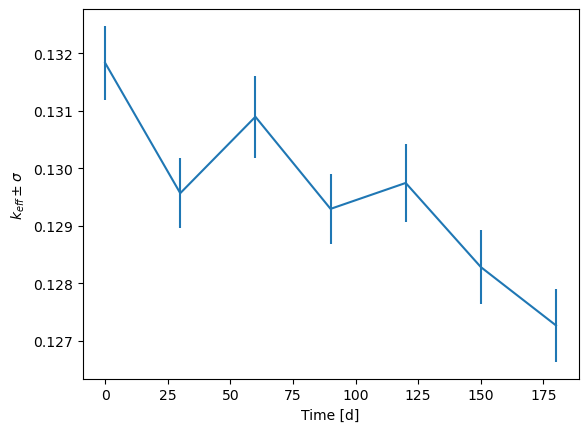

In [22]:
plt.errorbar(time, k[:, 0], yerr=k[:, 1])
plt.xlabel("Time [d]")
plt.ylabel("$k_{eff}\pm \sigma$");

In [23]:
_, u235 = results.get_atoms("1", "U235")
_, xe135 = results.get_atoms("1", "Xe135")
_,he4=results.get_atoms("2","He4")
_,ni58=results.get_atoms("2","Ni58")
_,ni59=results.get_atoms("2","Ni59")
_,Fe56=results.get_atoms("2","Fe56")
_,u235=results.get_atoms("1","U235")
_,u238=results.get_atoms("1","U238")
_,pu239=results.get_atoms("1","Pu239")
_,pu238=results.get_atoms("1","Pu238")

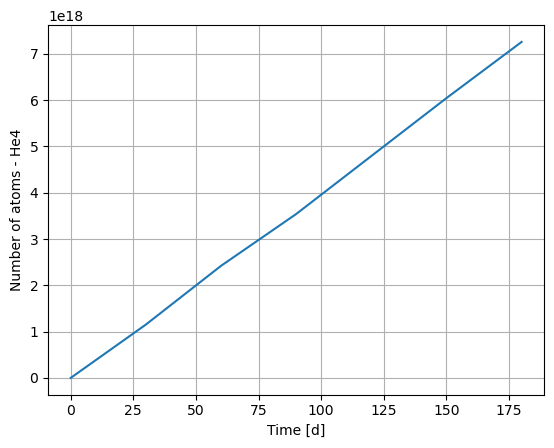

In [24]:
plt.plot(time, he4*100, label="He4")
plt.xlabel("Time [d]")
plt.ylabel("Number of atoms - He4");
plt.grid()

# Tallies

In [25]:
# Neutron spectrum
tally_list = []

n_groups = 500
Emin = 1e-5
Emax = 20e6

energies = np.logspace(log10(Emin), log10(Emax), n_groups+1)

energy_filter = openmc.EnergyFilter(energies)

spectrum = openmc.Tally(name = "Neutron Spectrum")
spectrum.filters = [energy_filter]
spectrum.scores = ['flux']

tally_list.append(spectrum)

In [26]:
tallies = openmc.Tallies(tally_list)
tallies.export_to_xml()

In [27]:
openmc.run()

[Matteo-Device:79308] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.Matteo-Device.1000/jf.0/3504603136/shared_mem_cuda_pool.Matteo-Device could be created.
[Matteo-Device:79308] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%

In [28]:
sp = openmc.StatePoint('statepoint.50.h5')

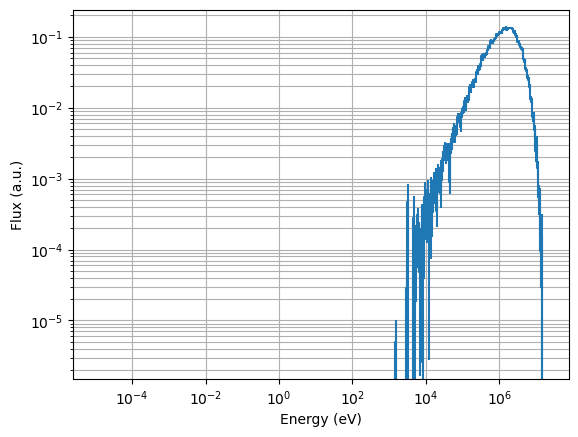

In [29]:
# Neutron spectrum
spectrum_tally = sp.get_tally(name = "Neutron Spectrum")

e_filter = spectrum_tally.filters[0]
E = e_filter.bins[:,0]

spectrum_mean = spectrum_tally.get_values(value = 'mean').ravel()
spectrum_std_dev = spectrum_tally.get_values(value = 'std_dev').ravel()

# Plot
fig, ax = plt.subplots()
plt.errorbar(E, spectrum_mean,spectrum_std_dev, ds = 'steps')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Flux (a.u.)")
ax.grid(True, which = 'both')
#plt.savefig('./energy_flux.pdf', format='pdf', dpi = 600, bbox_inches = 'tight')

# Note
Il k-efficace è molto piccolo in quanto sto simulando un "full-core" quindi si deve raggiungere massa critica, come? con molti più fuel-assembly qui ce ne sono solamente 19 ma il core di ALFRED è fatto da 171FA, quindi questo è il motivo per cui non si è critici qui. Inoltre come boundary esterna ho praticamente "vacuum" quindi qui i neutroni li perdo!